In [1]:
import os
import openpyxl
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from lightgbm import LGBMRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

## Load Data

In [2]:
all_files = []

data_dir = os.path.join("..", "data")
lindt_data_dir = os.path.join(data_dir, "ExtractiondeLINDT")
subfolders = [f.path for f in os.scandir(lindt_data_dir) if f.is_dir()]
for folder in subfolders:
    current_files = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    all_files.extend(current_files)
print(all_files)

['..\\data\\ExtractiondeLINDT\\01\\sem01.xlsx', '..\\data\\ExtractiondeLINDT\\01\\sem02.xlsx', '..\\data\\ExtractiondeLINDT\\01\\sem03.xlsx', '..\\data\\ExtractiondeLINDT\\01\\sem04.xlsx', '..\\data\\ExtractiondeLINDT\\01\\sem05.xlsx', '..\\data\\ExtractiondeLINDT\\02\\sem06.xlsx', '..\\data\\ExtractiondeLINDT\\02\\sem07.xlsx', '..\\data\\ExtractiondeLINDT\\02\\sem08.xlsx', '..\\data\\ExtractiondeLINDT\\02\\sem09.xlsx', '..\\data\\ExtractiondeLINDT\\03\\sem10.xlsx', '..\\data\\ExtractiondeLINDT\\04\\01avril23.xlsx', '..\\data\\ExtractiondeLINDT\\04\\1avril23.xlsx', '..\\data\\ExtractiondeLINDT\\04\\2avril23.xlsx', '..\\data\\ExtractiondeLINDT\\04\\3avril23.xlsx', '..\\data\\ExtractiondeLINDT\\05\\1mail23.xlsx', '..\\data\\ExtractiondeLINDT\\05\\2mai23.xlsx', '..\\data\\ExtractiondeLINDT\\05\\3mai23.xlsx', '..\\data\\ExtractiondeLINDT\\05\\4mai23.xlsx', '..\\data\\ExtractiondeLINDT\\05\\5mai23.xlsx', '..\\data\\ExtractiondeLINDT\\06\\1Juin23.xlsx', '..\\data\\ExtractiondeLINDT\\06\\2Jui

In [3]:
df = None

for i, path in enumerate(all_files):
    workbook = openpyxl.load_workbook(path)
    worksheet = workbook["Extraction1"]
    current_date = worksheet["G9"].value.split(" ")[-1]

    current_df = pd.read_excel(path, header=17)

    current_df["File_Index"] = i
    current_df["Date"] = pd.to_datetime(current_date, format='%d/%m/%Y')
    df = pd.concat([df, current_df], ignore_index=True)

df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df["Year_Month"] = df["Date"].dt.strftime('%Y_%m')

df.head()

,Code Secteur,Libellé Secteur,Code Rayon,Libellé Rayon,Code Groupe de Famille,Libellé Groupe de Famille,Code Famille,Libellé Famille,Code Sous-Famille,Libellé Sous-Famille,...,Quantité vendue *,Type Qté,Stock en quantité,Unnamed: 30,Unnamed: 31,File_Index,Date,Month,Year,Year_Month
0,1,PGC,14,EPICERIE,140,PDTS POUR PETITS DEJEUNERS,1404,PATES A TARTINER,0,PATE A TARTINER,...,NaN,UVC,0,NaN,1,0,2024-01-06,1,2024,2024_01
1,1,PGC,14,EPICERIE,142,CONFISERIE,1420,TABLETTES DE CHOCOLAT,0,DESSERT,...,NaN,UVC,17,NaN,1,0,2024-01-06,1,2024,2024_01
2,1,PGC,14,EPICERIE,142,CONFISERIE,1420,TABLETTES DE CHOCOLAT,0,DESSERT,...,NaN,UVC,0,NaN,1,0,2024-01-06,1,2024,2024_01
3,1,PGC,14,EPICERIE,142,CONFISERIE,1420,TABLETTES DE CHOCOLAT,0,DESSERT,...,NaN,UVC,0,NaN,1,0,2024-01-06,1,2024,2024_01
4,1,PGC,14,EPICERIE,142,CONFISERIE,1420,TABLETTES DE CHOCOLAT,0,DESSERT,...,NaN,UVC,24,NaN,2,0,2024-01-06,1,2024,2024_01


## Remove Unnecessary Columns

In [4]:
df = df.drop(df.columns[:15], axis=1)
columns_to_keep = [col for col in df.columns if "Unnamed" not in col]
df = df[columns_to_keep]
columns_to_drop = ["Article Libellé Court", "Type PA", "SRP", "Indicateur PVC", "Type PV Mag", "Indicateur PV Mag", "Type Qté"] # specific columns which we don't need 
df = df.drop(columns=columns_to_drop)
df.head()

,EAN,Article Libellé Long,PAHT,PVC,PV Mag,TVA en %,Quantité vendue *,Stock en quantité,File_Index,Date,Month,Year,Year_Month
0,8013108699504,200G PATE A TARTINER 25%,4.31,4.99,4.99,0.055,NaN,0,0,2024-01-06,1,2024,2024_01
1,3046920021043,200G DESSERT NR 70% INTEN,2.50,3.25,3.25,0.055,NaN,17,0,2024-01-06,1,2024,2024_01
2,3046920026666,DESSERT NR EXTRA FONDANT,1.92,2.19,2.19,0.055,NaN,0,0,2024-01-06,1,2024,2024_01
3,3046920026826,A CUISINER 70% CACAO 180G,1.79,2.58,2.58,0.055,NaN,0,0,2024-01-06,1,2024,2024_01
4,3046920021463,200GX2 DESSERT NR 70% INT,4.79,5.69,5.69,0.055,NaN,24,0,2024-01-06,1,2024,2024_01


## Clean the values

In [5]:
df = df[~df["PAHT"].isna()]
df = df[~df["PVC"].isna()]
df["Quantité vendue *"] = df["Quantité vendue *"].fillna(0)
df.reset_index(drop=True, inplace=True)
df

,EAN,Article Libellé Long,PAHT,PVC,PV Mag,TVA en %,Quantité vendue *,Stock en quantité,File_Index,Date,Month,Year,Year_Month
0,8013108699504,200G PATE A TARTINER 25%,4.31,4.99,4.99,0.055,0.0,0,0,2024-01-06,1,2024,2024_01
1,3046920021043,200G DESSERT NR 70% INTEN,2.50,3.25,3.25,0.055,0.0,17,0,2024-01-06,1,2024,2024_01
2,3046920026666,DESSERT NR EXTRA FONDANT,1.92,2.19,2.19,0.055,0.0,0,0,2024-01-06,1,2024,2024_01
3,3046920026826,A CUISINER 70% CACAO 180G,1.79,2.58,2.58,0.055,0.0,0,0,2024-01-06,1,2024,2024_01
4,3046920021463,200GX2 DESSERT NR 70% INT,4.79,5.69,5.69,0.055,0.0,24,0,2024-01-06,1,2024,2024_01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7002,3046920012089,137G SACH OURS TEDDY LAIT,4.91,5.69,5.69,0.055,0.0,0,48,2023-12-30,12,2023,2023_12
7003,4000539669804,LINDT LAPIN LAIT NOISETTE,3.38,3.85,3.85,0.200,0.0,102,48,2023-12-30,12,2023,2023_12
7004,4000539697807,LAPIN OR LAIT FLEURS 100G,3.19,2.30,2.30,0.200,0.0,0,48,2023-12-30,12,2023,2023_12
7005,4000539647000,LINDT POUSSIN LAIT MOULAG,2.76,3.70,3.49,0.200,0.0,0,48,2023-12-30,12,2023,2023_12


## Custom calculations

In [6]:
df["Buying Cost without Taxes"] = round(df["PAHT"] * df["Quantité vendue *"], 2)
df["Buying Cost with Taxes"] = round(df["PAHT"] * df["Quantité vendue *"] * (1 + df["TVA en %"]), 2)
df["Revenue"] = round(df["PVC"] * df["Quantité vendue *"], 2)
df["Profit"] = df["Revenue"] - df["Buying Cost with Taxes"]
df.head()

,EAN,Article Libellé Long,PAHT,PVC,PV Mag,TVA en %,Quantité vendue *,Stock en quantité,File_Index,Date,Month,Year,Year_Month,Buying Cost without Taxes,Buying Cost with Taxes,Revenue,Profit
0,8013108699504,200G PATE A TARTINER 25%,4.31,4.99,4.99,0.055,0.0,0,0,2024-01-06,1,2024,2024_01,0.0,0.0,0.0,0.0
1,3046920021043,200G DESSERT NR 70% INTEN,2.50,3.25,3.25,0.055,0.0,17,0,2024-01-06,1,2024,2024_01,0.0,0.0,0.0,0.0
2,3046920026666,DESSERT NR EXTRA FONDANT,1.92,2.19,2.19,0.055,0.0,0,0,2024-01-06,1,2024,2024_01,0.0,0.0,0.0,0.0
3,3046920026826,A CUISINER 70% CACAO 180G,1.79,2.58,2.58,0.055,0.0,0,0,2024-01-06,1,2024,2024_01,0.0,0.0,0.0,0.0
4,3046920021463,200GX2 DESSERT NR 70% INT,4.79,5.69,5.69,0.055,0.0,24,0,2024-01-06,1,2024,2024_01,0.0,0.0,0.0,0.0


In [7]:
df.to_csv("./lindt_cleaned.csv", index=False)

## Data Analysis

### Total Revenues

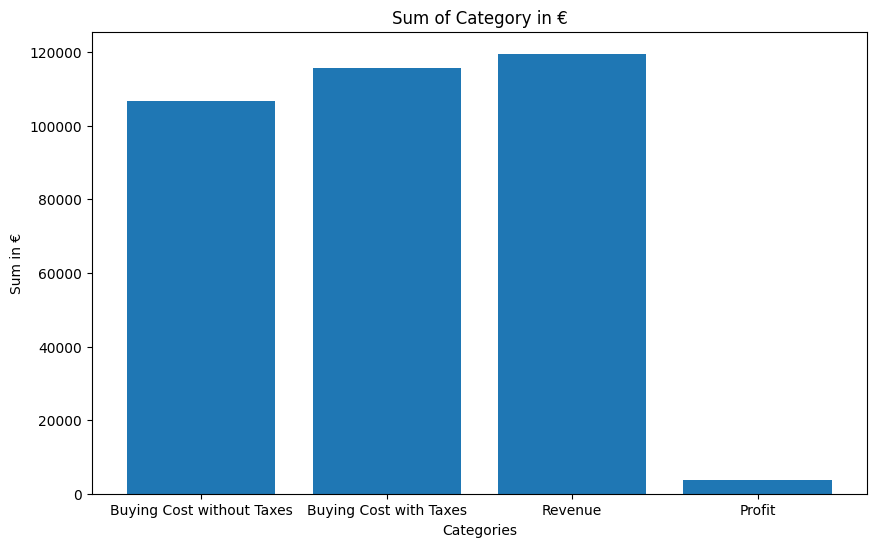

In [8]:
columns = ["Buying Cost without Taxes", "Buying Cost with Taxes", "Revenue", "Profit"]
sum_values = []

for column in columns:
    sum_values.append(round(df[column].sum(),2))

plt.figure(figsize=(10,6))
plt.bar(columns, sum_values)
plt.xlabel("Categories")
plt.ylabel("Sum in €")
plt.title("Sum of Category in €")
plt.show()

### Revenues by Month

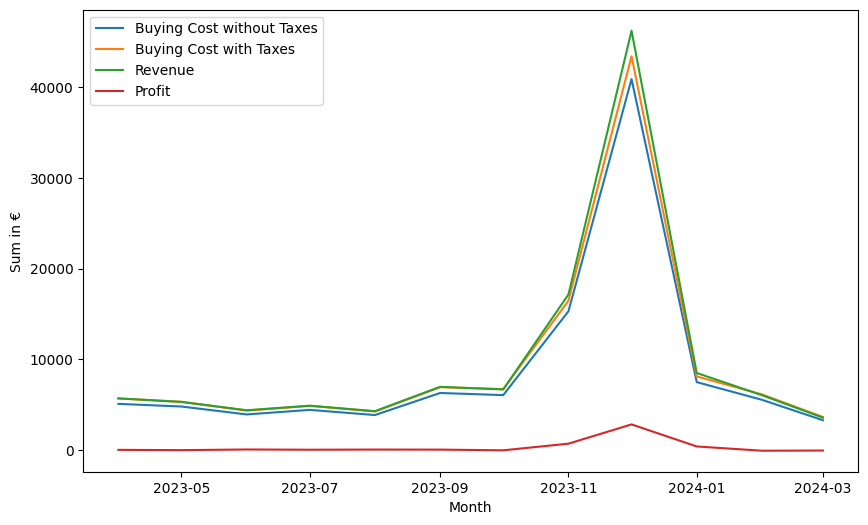

In [9]:
revenue_df = df.copy()
revenue_df['Year_Month'] = pd.to_datetime(revenue_df['Year_Month'], format='%Y_%m')
revenue_df = revenue_df.sort_values(by='Year_Month')

sum_values_by_month = []
for column in columns:
    current_values = revenue_df.groupby("Year_Month")[column].sum()
    sum_values_by_month.append(current_values.round(2).tolist())
months = revenue_df['Year_Month'].unique().tolist()

plt.figure(figsize=(10,6))
for i, values in enumerate(sum_values_by_month, start=0):
    plt.plot(months, values, label=columns[i])
plt.xlabel("Month")
plt.ylabel("Sum in €")
plt.legend()
plt.show()

del revenue_df

### Revenues by Date

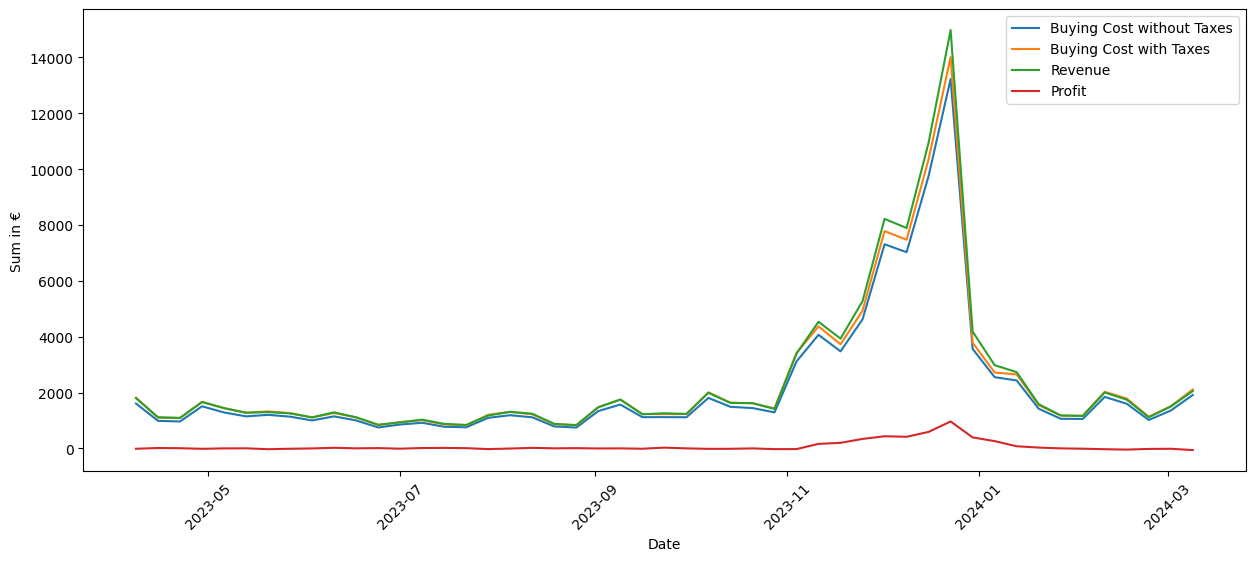

In [10]:
revenue_df = df.copy()
revenue_df = revenue_df.sort_values(by='Date')

sum_values_by_month_week = []
for column in columns:
    current_values = revenue_df.groupby("Date")[column].sum()
    sum_values_by_month_week.append(current_values.round(2).tolist())
month_weeks = revenue_df['Date'].unique().tolist()

plt.figure(figsize=(15,6))
for i, values in enumerate(sum_values_by_month_week, start=0):
    plt.plot(month_weeks, values, label=columns[i])
plt.xlabel("Date")
plt.ylabel("Sum in €")
plt.xticks(rotation=45)
plt.legend()
plt.show()

del revenue_df

### Revenues by Product (best Products)

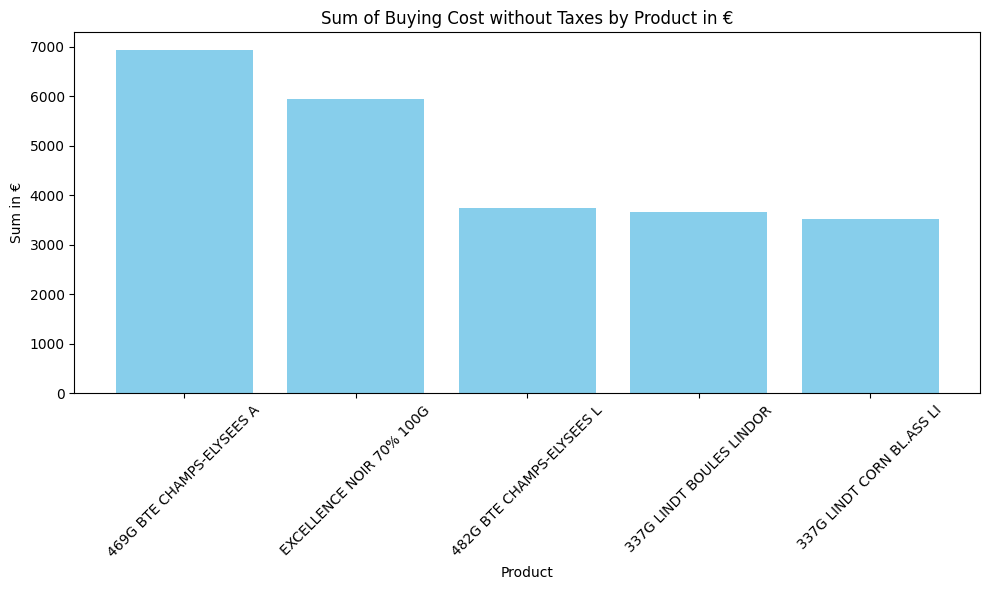

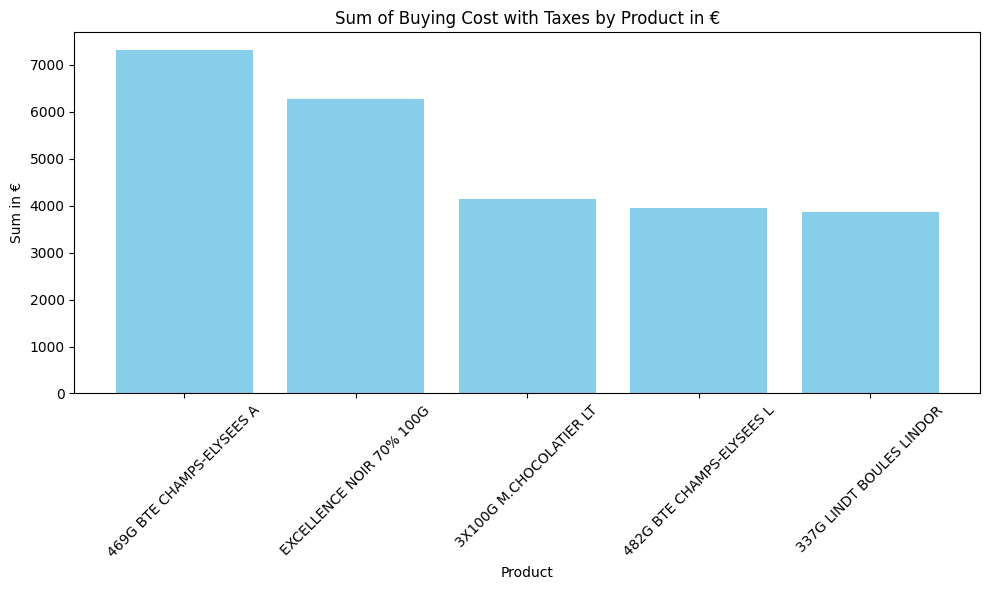

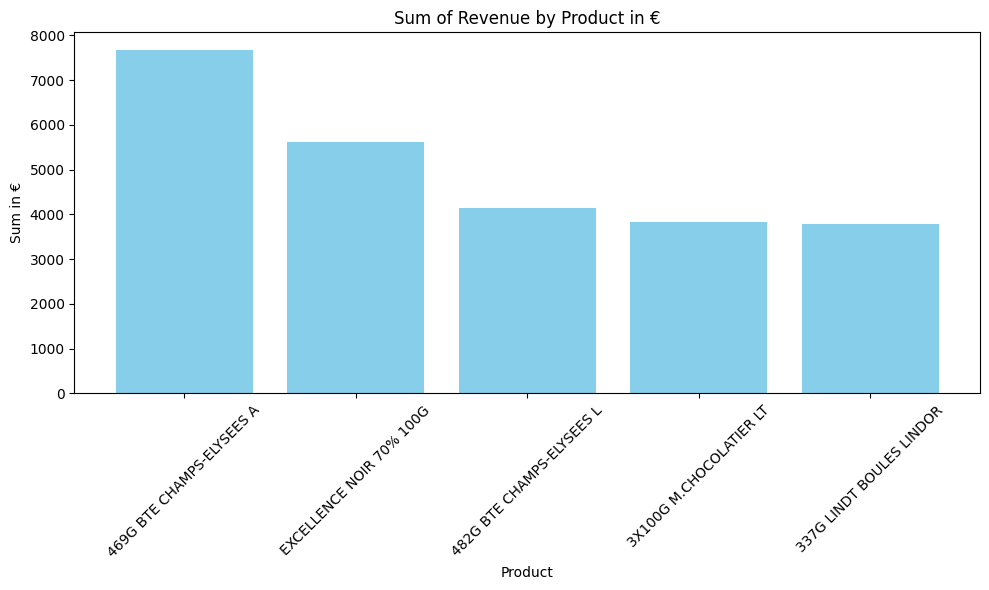

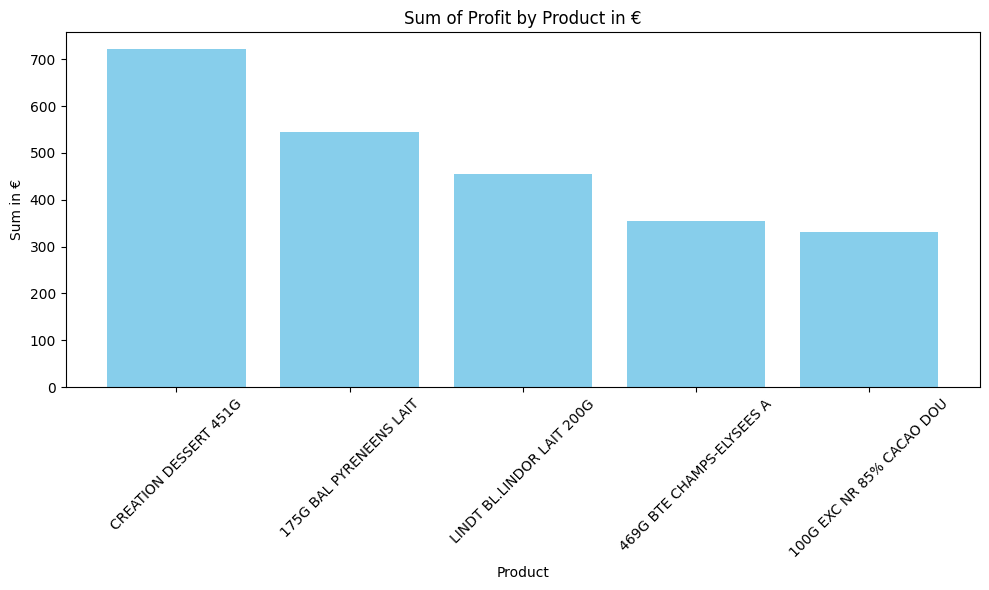

In [11]:
sum_values_by_product = []
for column in columns:
    current_values = df.groupby("Article Libellé Long")[column].sum()
    sum_values_by_product.append(current_values.round(2))
for i, series in enumerate(sum_values_by_product):
    top_5_index = series.nlargest(5).index
    top_5_rows = series.loc[top_5_index]
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(top_5_rows.index, top_5_rows.values, color='skyblue')  # Replace 'column_name' and 'value_column' with your column names
    plt.xlabel('Product')  # Set the label for the x-axis
    plt.ylabel('Sum in €')  # Set the label for the y-axis
    plt.title(f'Sum of {columns[i]} by Product in €')  # Set the title of the plot
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

## Machine Learning Model

### Revenue Prediction

In [12]:
revenue_df = df.copy()
revenue_data = df.groupby("Date")["Revenue"].sum()
revenue_df = pd.Series(revenue_data).reset_index().rename(columns={'Date': 'Date', 'Revenue': 'Revenue'})
revenue_df["Revenue"] = round(revenue_df["Revenue"]/7,2)
revenue_df = revenue_df.set_index('Date')

# Resample the DataFrame to fill in missing dates with the next row's revenue value
revenue_df = revenue_df.resample('D').ffill()

# Reset the index to make 'Date' a column again
revenue_df = revenue_df.reset_index()

revenue_df["Year"] = revenue_df["Date"].dt.year
revenue_df["Month"] = revenue_df["Date"].dt.month
revenue_df["Day"] = revenue_df["Date"].dt.day
revenue_df["Day_of_week"] = revenue_df["Date"].dt.day_of_week

revenue_df = revenue_df.dropna()
revenue_df.reset_index(drop=True, inplace=True)

revenue_df.head()

,Date,Revenue,Year,Month,Day,Day_of_week
0,2023-04-08,257.98,2023,4,8,5
1,2023-04-09,257.98,2023,4,9,6
2,2023-04-10,257.98,2023,4,10,0
3,2023-04-11,257.98,2023,4,11,1
4,2023-04-12,257.98,2023,4,12,2


In [13]:
X = revenue_df[["Year", "Month", "Day", "Day_of_week"]]
y = revenue_df["Revenue"]

tscv = TimeSeriesSplit(n_splits=5)

model = LinearRegression()

In [14]:
actual_values = []
predicted_values = []
mse_scores = []
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    actual_values.extend(y_test.values)
    predicted_values.extend(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

mean_mse = np.mean(mse_scores)
print("Mean Squarred Error", mean_mse)

Mean Squarred Error 220646.4553579092


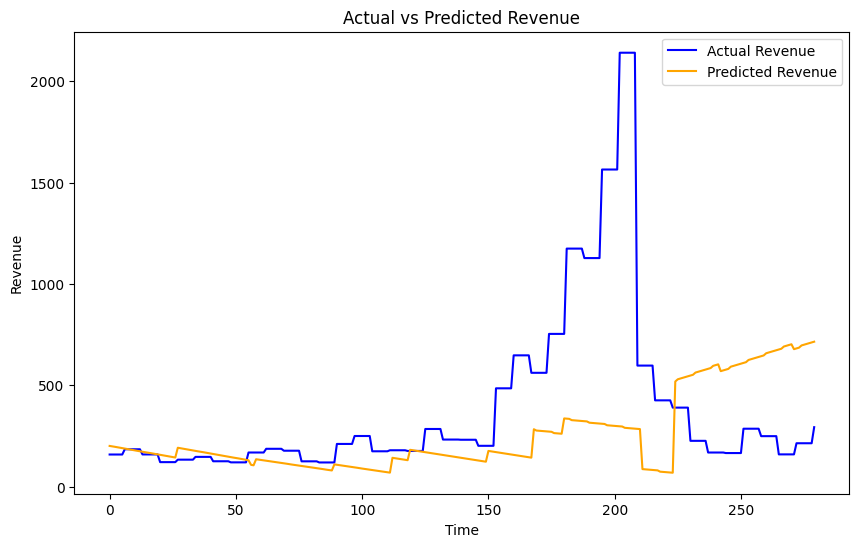

In [15]:
# Plot actual vs predicted revenue
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Revenue', color='blue')
plt.plot(predicted_values, label='Predicted Revenue', color='orange')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue')
plt.legend()
plt.show()

In [16]:
future_dates = pd.date_range(start='2024-04-13', end='2024-04-20')  # Example future dates
future_features = pd.DataFrame({
    'Year': future_dates.year,
    'Month': future_dates.month,
    'Day': future_dates.day,
    'Day_of_week': future_dates.dayofweek
})
future_revenues = model.predict(future_features)

# Display predicted revenues for future dates
future_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Revenue': future_revenues
})
print(future_predictions)

        Date  Predicted_Revenue
0 2024-04-13         843.842650
1 2024-04-14         847.540946
2 2024-04-15         858.481327
3 2024-04-16         862.179623
4 2024-04-17         865.877918
5 2024-04-18         869.576214
6 2024-04-19         873.274510
7 2024-04-20         876.972805


In [17]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

### Revenue Prediction with Mean Revenue of last 21 days

In [18]:
revenue_mean_df = df.copy()
revenue_mean_data = df.groupby("Date")["Revenue"].sum()
revenue_mean_df = pd.Series(revenue_mean_data).reset_index().rename(columns={'Date': 'Date', 'Revenue': 'Revenue'})
revenue_mean_df["Revenue"] = round(revenue_mean_df["Revenue"]/7,2)
revenue_mean_df = revenue_mean_df.set_index('Date')

# Resample the DataFrame to fill in missing dates with the next row's revenue value
revenue_mean_df = revenue_mean_df.resample('D').ffill()

# Reset the index to make 'Date' a column again
revenue_mean_df = revenue_mean_df.reset_index()

revenue_mean_df["Year"] = revenue_mean_df["Date"].dt.year
revenue_mean_df["Month"] = revenue_mean_df["Date"].dt.month
revenue_mean_df["Day"] = revenue_mean_df["Date"].dt.day
revenue_mean_df["Day_of_week"] = revenue_mean_df["Date"].dt.day_of_week
revenue_mean_df['Revenue Mean'] = revenue_mean_df['Revenue'].rolling(21).mean().shift(1)

revenue_mean_df = revenue_mean_df.dropna()
revenue_mean_df.reset_index(drop=True, inplace=True)

revenue_mean_df.head()

,Date,Revenue,Year,Month,Day,Day_of_week,Revenue Mean
0,2023-04-29,237.33,2023,4,29,5,191.503333
1,2023-04-30,237.33,2023,4,30,6,190.520000
2,2023-05-01,237.33,2023,5,1,0,189.536667
3,2023-05-02,237.33,2023,5,2,1,188.553333
4,2023-05-03,237.33,2023,5,3,2,187.570000


In [19]:
X_mean = revenue_mean_df[["Year", "Month", "Day", "Day_of_week", "Revenue Mean"]]
y_mean = revenue_mean_df["Revenue"]

tscv_mean = TimeSeriesSplit(n_splits=5)

model_mean = LinearRegression()

In [20]:
actual_mean_values = []
predicted_mean_values = []
mse_mean_scores = []
for train_idx, test_idx in tscv_mean.split(X_mean):
    X_train, X_test = X_mean.iloc[train_idx], X_mean.iloc[test_idx]
    y_train, y_test = y_mean.iloc[train_idx], y_mean.iloc[test_idx]

    model_mean.fit(X_train, y_train)

    y_pred = model_mean.predict(X_test)
    actual_mean_values.extend(y_test.values)
    predicted_mean_values.extend(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    mse_mean_scores.append(mse)

mean_mse = np.mean(mse_mean_scores)
print("Mean Squarred Error", mean_mse)

Mean Squarred Error 266071.826389436


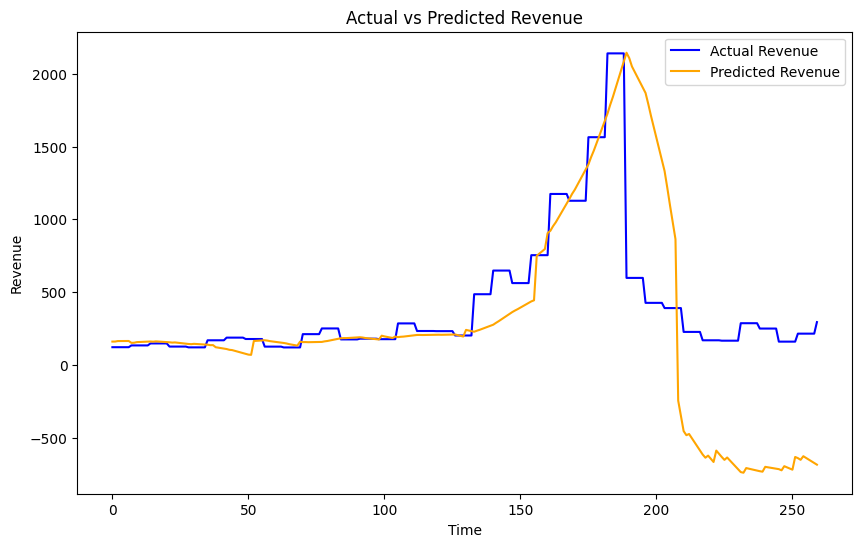

In [21]:
# Plot actual vs predicted revenue
plt.figure(figsize=(10, 6))
plt.plot(actual_mean_values, label='Actual Revenue', color='blue')
plt.plot(predicted_mean_values, label='Predicted Revenue', color='orange')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue')
plt.legend()
plt.show()

In [22]:
future_dates = pd.date_range(start='2024-04-13', end='2024-04-20')  # Example future dates
future_features = pd.DataFrame({
    'Year': future_dates.year,
    'Month': future_dates.month,
    'Day': future_dates.day,
    'Day_of_week': future_dates.dayofweek,
    "Revenue Mean": [500 for i in range(len(future_dates))]
})
future_revenues = model_mean.predict(future_features)

# Display predicted revenues for future dates
future_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Revenue': future_revenues
})
print(future_predictions)

        Date  Predicted_Revenue
0 2024-04-13        -331.026192
1 2024-04-14        -338.656838
2 2024-04-15        -310.001826
3 2024-04-16        -317.632472
4 2024-04-17        -325.263119
5 2024-04-18        -332.893766
6 2024-04-19        -340.524412
7 2024-04-20        -348.155059


In [23]:
with open('model_mean.pkl', 'wb') as f:
    pickle.dump(model_mean, f)

### ARIMA Model

In [24]:
arima_df = revenue_df[["Date", "Revenue"]]
arima_df.set_index("Date", inplace=True)
adf_test = adfuller(arima_df["Revenue"])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.357907
p-value: 0.153971


In [25]:
arima_model = ARIMA(arima_df["Revenue"], order=(1,0,1))
model_fit = arima_model.fit()
forecast = model_fit.get_forecast(steps=30)

c:\Users\ZBook\Documents\GitHub\Advanced_Analytics_Applied\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ZBook\Documents\GitHub\Advanced_Analytics_Applied\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ZBook\Documents\GitHub\Advanced_Analytics_Applied\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


c:\Users\ZBook\Documents\GitHub\Advanced_Analytics_Applied\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ZBook\Documents\GitHub\Advanced_Analytics_Applied\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ZBook\Documents\GitHub\Advanced_Analytics_Applied\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


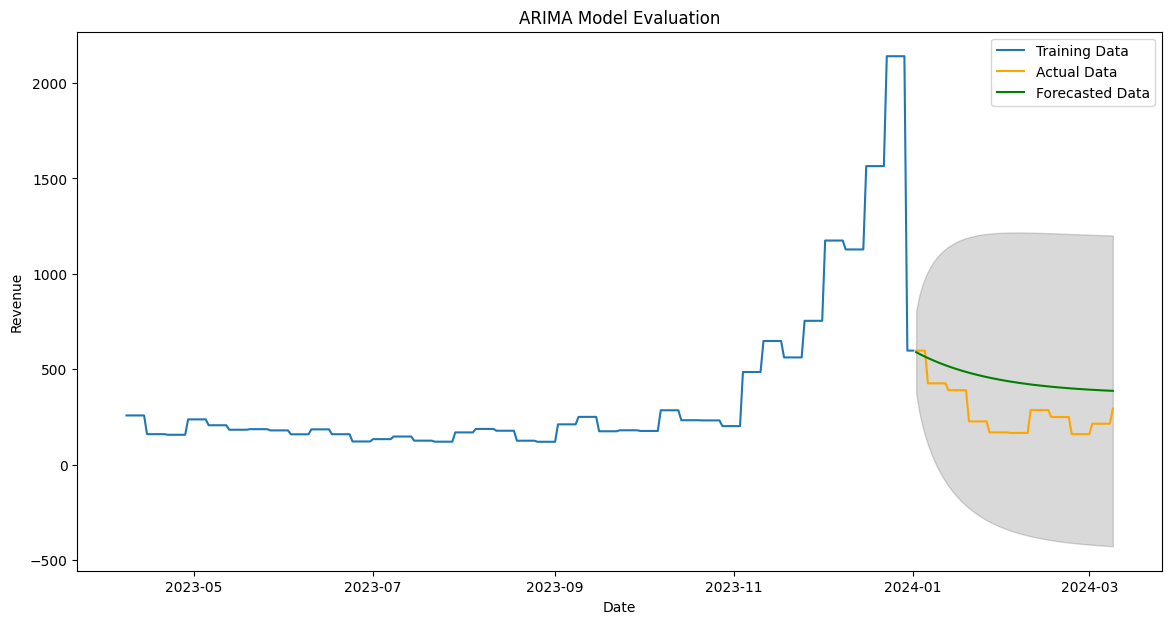

MSE: 36975.51152097428


In [26]:
# Split the data into train and test
train_size = int(len(arima_df) * 0.8)
train, test = arima_df[0:train_size], arima_df[train_size:len(arima_df)]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['Revenue'], order=(1, 0, 1))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Calculate the mean squared error
mse = mean_squared_error(test['Revenue'], test_forecast_series)

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train['Revenue'], label='Training Data')
plt.plot(test['Revenue'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

print('MSE:', mse)

In [27]:
prediction = model_train_fit.get_prediction(start=pd.to_datetime('2025-01-13'), dynamic=False)
print(prediction.predicted_mean)

2025-01-13    368.428127
Freq: D, dtype: float64


### Light Gradient Boosting Machine

In [28]:
X = revenue_df[["Year", "Month", "Day", "Day_of_week"]]
y = revenue_df["Revenue"]

tscv = TimeSeriesSplit(n_splits=5)

lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)

for train_idx, test_idx in tscv_mean.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    lgbm_model.fit(X_train, y_train)

    y_pred = lgbm_model.predict(X_test)
    actual_mean_values.extend(y_test.values)
    predicted_mean_values.extend(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    mse_mean_scores.append(mse)

mean_mse = np.mean(mse_mean_scores)
print("Mean Squarred Error", mean_mse)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 3
[LightGBM] [Info] Start training from score 195.248072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

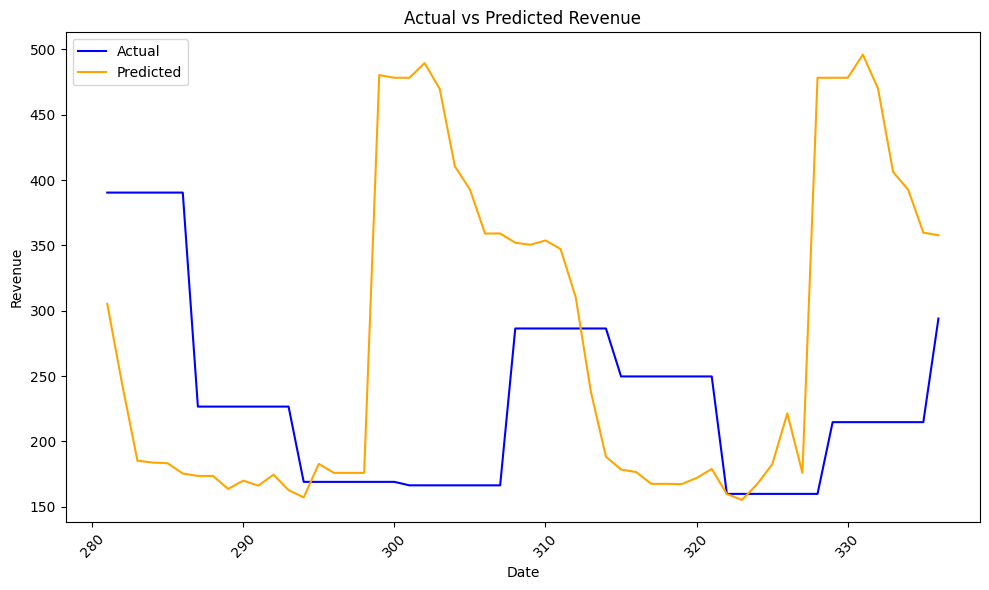

In [29]:
# Plot actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='orange')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue')
plt.legend()

# Show plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()       # Adjust layout to prevent overlapping labels
plt.show()

In [30]:
future_dates = pd.date_range(start='2024-04-13', end='2024-04-20')  # Example future dates
future_features = pd.DataFrame({
    'Year': future_dates.year,
    'Month': future_dates.month,
    'Day': future_dates.day,
    'Day_of_week': future_dates.dayofweek,
})
future_revenues = lgbm_model.predict(future_features)

# Display predicted revenues for future dates
future_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Revenue': future_revenues
})
print(future_predictions)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
        Date  Predicted_Revenue
0 2024-04-13         341.669566
1 2024-04-14         305.251167
2 2024-04-15         243.123919
3 2024-04-16         185.185982
4 2024-04-17         183.786586
5 2024-04-18         183.249530
6 2024-04-19         175.404857
7 2024-04-20         173.552348


In [31]:
with open('lgbm_model.pkl', 'wb') as f:
    pickle.dump(lgbm_model, f)

### LGBM with Mean Revenue

In [32]:
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)

for train_idx, test_idx in tscv_mean.split(X_mean):
    X_train, X_test = X_mean.iloc[train_idx], X_mean.iloc[test_idx]
    y_train, y_test = y_mean.iloc[train_idx], y_mean.iloc[test_idx]

    lgbm_model.fit(X_train, y_train)

    y_pred = lgbm_model.predict(X_test)
    actual_mean_values.extend(y_test.values)
    predicted_mean_values.extend(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    mse_mean_scores.append(mse)

mean_mse = np.mean(mse_mean_scores)
print("Mean Squarred Error", mean_mse)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 4
[LightGBM] [Info] Start training from score 187.043751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

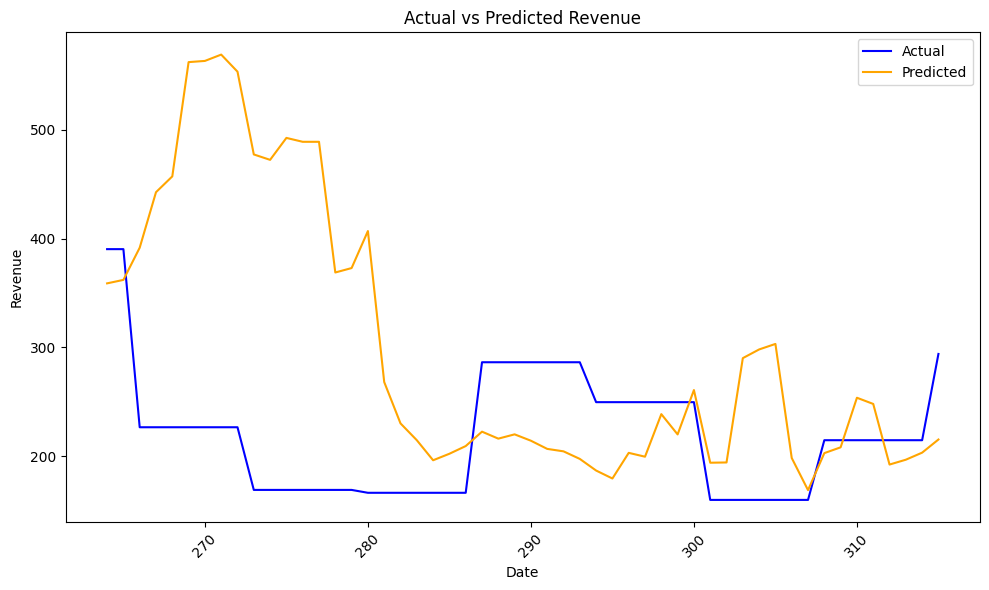

In [33]:
# Plot actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='orange')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue')
plt.legend()

# Show plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()       # Adjust layout to prevent overlapping labels
plt.show()

In [39]:
future_dates = pd.date_range(start='2024-04-13', end='2024-12-31')  # Example future dates
future_features = pd.DataFrame({
    'Year': future_dates.year,
    'Month': future_dates.month,
    'Day': future_dates.day,
    'Day_of_week': future_dates.dayofweek,
    "Revenue Mean": [500 for i in range(len(future_dates))]
})
future_revenues = lgbm_model.predict(future_features)

# Display predicted revenues for future dates
future_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Revenue': future_revenues,
    'Supplier': ['Lindt' for i in range(len(future_revenues))]
})
print(future_predictions)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
          Date  Predicted_Revenue Supplier
0   2024-04-13         394.427377    Lindt
1   2024-04-14         416.903730    Lindt
2   2024-04-15         417.681238    Lindt
3   2024-04-16         404.732497    Lindt
4   2024-04-17         392.898446    Lindt
..         ...                ...      ...
258 2024-12-27        1512.813067    Lindt
259 2024-12-28        1435.466836    Lindt
260 2024-12-29        1244.396251    Lindt
261 2024-12-30        1380.542243    Lindt
262 2024-12-31        1380.542243    Lindt

[263 rows x 3 columns]


In [40]:
future_predictions.to_csv("lindt_prediction.csv")

In [35]:
with open('lgbm_model_mean.pkl', 'wb') as f:
    pickle.dump(lgbm_model, f)

### Neural Network

In [37]:
X = revenue_df[["Year", "Month", "Day", "Day_of_week"]]
y = revenue_df["Revenue"]

actual_mean_values = []
predicted_mean_values = []
mse_mean_scores = []

# Build and train the neural network model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with single neuron for regression
])

nn_model.compile(optimizer='adam', loss='mse')

tscv = TimeSeriesSplit()

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

    y_pred = nn_model.predict(X_test)
    actual_mean_values.extend(y_test.values)
    predicted_mean_values.extend(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    mse_mean_scores.append(mse)

mean_mse = np.mean(mse_mean_scores)
print("Mean Squarred Error", mean_mse)

Epoch 1/50
2/2 [==============================] - 1s 303ms/step - loss: 413352.0938 - val_loss: 275688.5312
Epoch 2/50
2/2 [==============================] - 0s 44ms/step - loss: 280901.1250 - val_loss: 170897.3594
Epoch 3/50
2/2 [==============================] - 0s 45ms/step - loss: 175273.0625 - val_loss: 94122.0625
Epoch 4/50
2/2 [==============================] - 0s 46ms/step - loss: 98971.6016 - val_loss: 43478.1992
Epoch 5/50
2/2 [==============================] - 0s 42ms/step - loss: 47921.2109 - val_loss: 13680.2939
Epoch 6/50
2/2 [==============================] - 0s 43ms/step - loss: 16612.4355 - val_loss: 1210.9059
Epoch 7/50
2/2 [==============================] - 0s 47ms/step - loss: 3640.0730 - val_loss: 1420.6924
Epoch 8/50
2/2 [==============================] - 0s 51ms/step - loss: 2472.1433 - val_loss: 8888.0283
Epoch 9/50
2/2 [==============================] - 0s 41ms/step - loss: 8120.9702 - val_loss: 18224.3125
Epoch 10/50
2/2 [==============================] - 0s 4

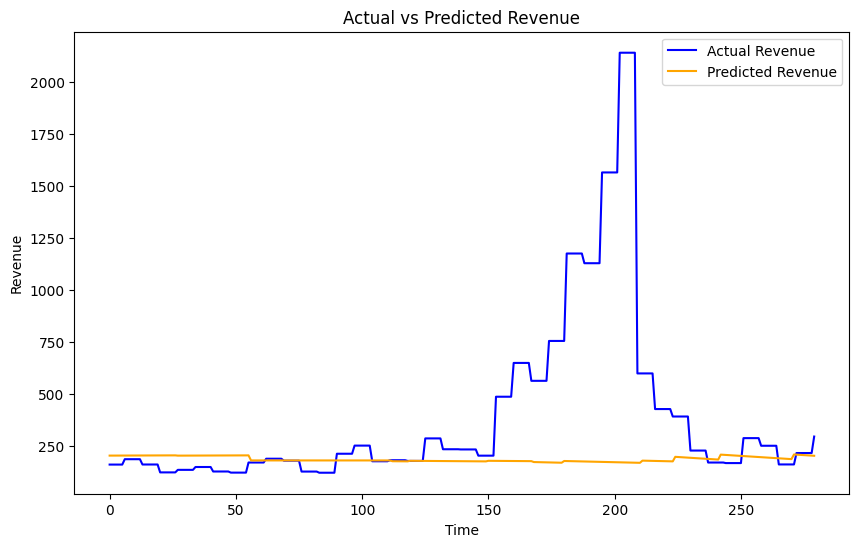

In [38]:
# Plot actual vs predicted revenue
plt.figure(figsize=(10, 6))
plt.plot(actual_mean_values, label='Actual Revenue', color='blue')
plt.plot(predicted_mean_values, label='Predicted Revenue', color='orange')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue')
plt.legend()
plt.show()

### Combine Predictions

In [46]:
lindt_prediction = pd.read_csv("./lindt_prediction.csv")
loreal_prediction = pd.read_csv("./loreal_prediction.csv")
all_predictions = pd.concat([lindt_prediction, loreal_prediction], axis=0)
all_predictions = all_predictions.drop(columns=["Unnamed: 0"])
all_predictions["Predicted_Revenue"] = round(all_predictions["Predicted_Revenue"], 2)
print(all_predictions)

           Date  Predicted_Revenue Supplier
0    2024-04-13             394.43    Lindt
1    2024-04-14             416.90    Lindt
2    2024-04-15             417.68    Lindt
3    2024-04-16             404.73    Lindt
4    2024-04-17             392.90    Lindt
..          ...                ...      ...
258  2024-12-27            1674.44  L'Oreal
259  2024-12-28            1637.04  L'Oreal
260  2024-12-29            1613.18  L'Oreal
261  2024-12-30            1646.11  L'Oreal
262  2024-12-31            1646.11  L'Oreal

[526 rows x 3 columns]


In [47]:
all_predictions.to_csv("all_predictions.csv", index=False)